In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import time
from sklearn.manifold import TSNE

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name)).split()
  f.close()
  
words = read_data(filename)
print('Data size %d' % len(words))


Data size 17005207


In [4]:
vocabulary_size = 5000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 2735459], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [0, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


* data : the index of word in dictionary
* count : word and word frequency
* vocabulary_size : top size of word frequency,the words would be instead of UNK whose frequency is less than size
* dictionary : word and word order in list
* reverse_dictionary : swap key and value of dicitonary

In [5]:
### make a Cbow model

def generate_batch(batch_size, window_size):
  global data_index
  assert batch_size % (2*window_size) == 0
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)
  span =  2*window_size + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size/(2*window_size)):
    target = window_size  # target label at the center of the buffer
    targets_to_avoid = [window_size]
    temp_array = np.arange(2*window_size+1)
    temp_array = np.delete(temp_array,window_size)
    for j in temp_array:
      while target in targets_to_avoid:
         target = np.arange(2*window_size+1)[j]
      targets_to_avoid.append(target)
      if j<window_size:
          batch[i * 2*window_size + j] = buffer[target]
          labels[i * 2*window_size + j,0] = buffer[window_size]
      else:
          batch[i * 2*window_size + j-1] = buffer[target]
          labels[i * 2*window_size + j-1,0] = buffer[window_size]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:12]])

for window_size in [2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=12, window_size=window_size)
    print('\nwith window_size = %d ' % window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(12)])

data: ['UNK', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']

with window_size = 2 
    batch: ['UNK', 'originated', 'a', 'term', 'originated', 'as', 'term', 'of', 'as', 'a', 'of', 'abuse']
    labels: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term']


In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.

window_size = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()
# ['Assign','Variable']
temp=[]
def device_for_node(n):
  temp.append(n.type)
  if n.type in ['MatMul']:
    gpu_list = ["/gpu:0"]
    gpu = random.choice(gpu_list)
    return gpu
  else:
    return "/cpu:0"
with graph.as_default():
    with graph.device(device_for_node):
      # Input data.
      train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
      train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
      valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

      # Variables.
      embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                             stddev=1.0 / math.sqrt(embedding_size)))
      softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

      # Model.
      
      # Look up embeddings for inputs.
      embed = tf.nn.embedding_lookup(embeddings, train_dataset)
      # Compute the softmax loss, using a sample of the negative labels each time.
      loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size))

      # Optimizer.
      optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

      # Compute the similarity between minibatch examples and all embeddings.
      # We use the cosine distance:
      norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
      normalized_embeddings = embeddings / norm
      valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
      similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
      global temp
      print(list(set(temp)))

[u'Slice', u'Const', u'Sub', u'ExpandDims', u'Reshape', u'Sum', u'Sqrt', u'Add', u'BroadcastGradientArgs', u'SoftmaxCrossEntropyWithLogits', u'RandomUniform', u'Tile', u'Mul', u'Prod', u'TruncatedNormal', u'Log', u'SparseApplyAdagrad', u'Transpose', u'Shape', u'Reverse', u'Neg', u'Variable', u'AddN', u'Squeeze', u'Placeholder', u'DynamicStitch', u'Concat', u'LogUniformCandidateSampler', u'Mean', u'SparseToDense', u'Gather', u'Cast', u'Range', u'Div', u'ComputeAccidentalHits', u'Assign', u'Pack', u'Square', u'Rank', u'MatMul', u'NoOp', u'Identity', u'Pad', u'Fill']


In [ ]:
num_steps = 100001
start = time.time()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
#allow_soft_placement=False,log_device_placement=False,gpu_options=gpu_options
with tf.Session(graph=graph,config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True,gpu_options=gpu_options)) as session:
  tf.initialize_all_variables().run()
 
  # Set logs writer into folder /tmp/tensorflow_logs
  summary_writer = tf.train.SummaryWriter('/home/wchen/tmp/tensorflow_logs', graph_def=session.graph_def)

  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, window_size)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()
final = time.time()
print(final-start)

Initialized
Average loss at step 0: 6.912741
Nearest to that: relations, runner, earlier, army, community, signing, movements, appear,
Nearest to american: worship, keeping, state, visited, old, build, indigenous, dallas,
Nearest to while: achieve, front, private, shares, collins, division, bombing, cavalry,
Nearest to only: alumni, follow, comes, looked, response, salt, hydrogen, cincinnati,
Nearest to no: fat, creating, examples, furthermore, williams, doctor, operation, profit,
Nearest to three: julius, error, directory, end, producing, abandoned, funeral, therapy,
Nearest to during: consider, highest, principle, secret, nuclear, cutting, wire, recent,
Nearest to as: register, cemetery, driven, rendered, centered, basic, distance, doesn,
Nearest to five: cleveland, compact, requires, john, areas, cultures, fun, comes,
Nearest to more: based, constant, germany, accessed, forests, book, fran, sacrifice,
Nearest to been: organization, important, horror, felt, crops, concerns, peoples, 

In [8]:
%matplotlib inline

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

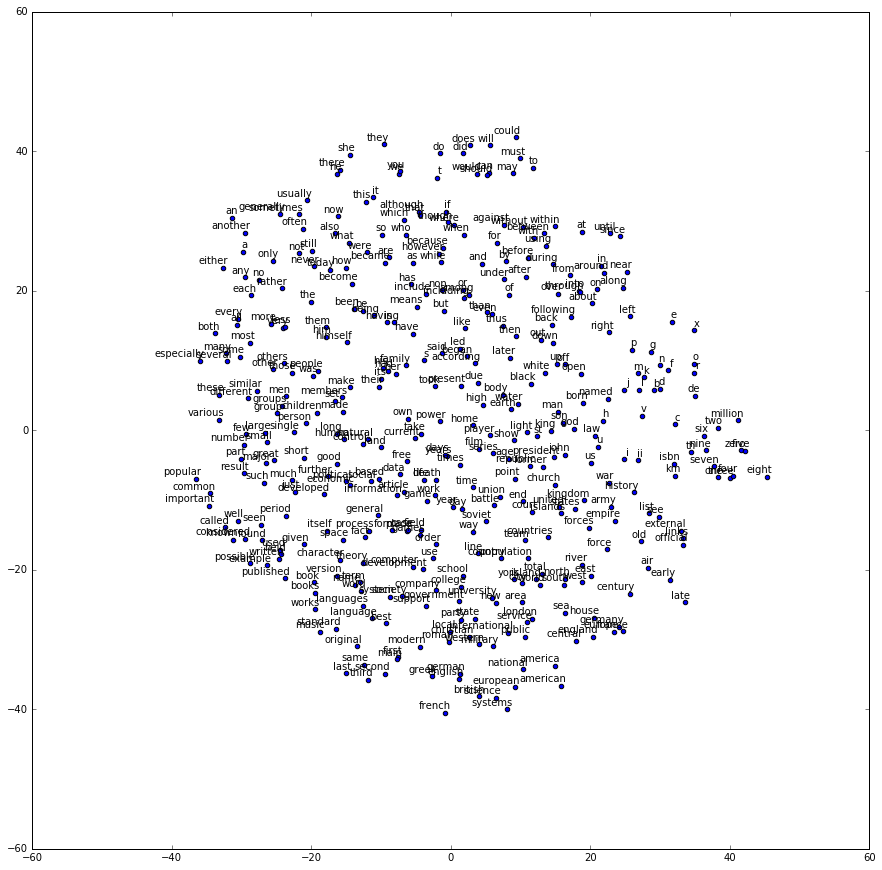

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)